In [19]:
import numpy as np
import matplotlib.pyplot as plt
import time, copy, warnings

import torch
import torchvision
import torchvision.transforms as transforms

from sklearn import linear_model, svm
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# MNIST dataset (images and labels) 

In [20]:
# Load the dataset and transform it into tensors and normalize between -1 and 1.

# Choose size as a power of 2
size = 4

transform = transforms.Compose([  
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,)) 
])



# Load MNIST train and test dataset
trainset = torchvision.datasets.MNIST(root='~/Documents/image_datasets/MNIST', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='~/Documents/image_datasets/MNIST', train=False, download=True, transform=transform)


num_train, num_test = len(trainset), len(testset)
print(f'number of (train, test) examples = {num_train, num_test}')


number of (train, test) examples = (60000, 10000)


## Binary Classification

In [21]:
def generate_subset_2(dataset, class1, class2):
    # Filter images for the selected classes
    class1_indices = torch.where(dataset.targets == class1)[0]
    class2_indices = torch.where(dataset.targets == class2)[0]

    # Concatenate indices from both classes
    selected_indices = torch.cat((class1_indices, class2_indices), dim=0)
    
    binary_dataset = torch.utils.data.Subset(dataset, selected_indices)
    
    X, y = [], []
    for image, label in binary_dataset:
        X.append(image.flatten().numpy())  # Convert image tensor to numpy array and add to features list
        y.append(label) 
    return np.array(X), np.array(y)


a = 4
b = 7
X_train, y_train = generate_subset_2(trainset, a, b)
X_test, y_test = generate_subset_2(testset, a, b)

num_train, num_test = X_train.shape[0], X_test.shape[0]
print(f'number of (train, test) examples = {num_train, num_test}')



number of (train, test) examples = (12107, 2010)


In [22]:
# change 4 to 0 and 7 to 1
y_train[y_train == a] = 0
y_train[y_train == b] = 1
y_test[y_test == a] = 0
y_test[y_test == b] = 1

In [23]:
#print a random image


image_6385 of size (4, 4) = (16,) :


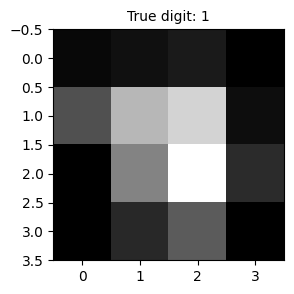

In [24]:
idx = np.random.randint(num_train)
image, label = X_train[idx], y_train[idx]
print(f'image_{idx} of size {(size, size)} = {image.shape} :')

plt.figure(figsize=(3,3))
plt.imshow(image.reshape(size, size), cmap='gray')
plt.title(f'True digit: {label}', fontsize=10)
plt.show()

## Data encodings

In [25]:
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit_machine_learning.circuit.library import RawFeatureVector
import numpy as np

def create_feature_map(size, encoding):
    """
    Creates a feature map circuit based on the specified encoding type.

    Parameters:
        size (int): The size of the features.
        encoding (str): The encoding type. Choose from 'Pauli', 'Z', 'ZZ', or 'RawFeatureVector'.

    Returns:
        qiskit.QuantumCircuit: The feature map quantum circuit.
    """

    num_features = size ** 2
    num_qubits = num_features

    if encoding == 'Pauli':
        fm = PauliFeatureMap(feature_dimension=num_features, reps=1, paulis=['Z'])
    elif encoding == 'Z':
        fm = ZFeatureMap(feature_dimension=num_features, reps=1)
    elif encoding == 'ZZ':
        fm = ZZFeatureMap(feature_dimension=num_features, reps=1)
    elif encoding == 'RawFeatureVector':
        num_qubits = int(np.log2(num_features))
        fm = RawFeatureVector(feature_dimension=num_features)
    else:
        raise ValueError("Invalid encoding type. Choose from 'Pauli', 'Z', 'ZZ', or 'RawFeatureVector'.")

    print(f'number of (features, qubits) = {num_features, num_qubits}')

    return fm, num_qubits

# Example usage:
size = 4
encoding = 'RawFeatureVector'
fm,num_qubits = create_feature_map(size, encoding)
fm.draw()


number of (features, qubits) = (16, 4)


»
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
«     ┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                                                                ├
«     │                                                                                                                 │
«q_1: ┤1                                                                                                                ├
«     │  Parameterizedinitialize(x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15]) │
«q_2: ┤2                                                                                                                ├
«     │                                                                                                                 │
«q_3: ┤3                                                                                                                ├
«     └─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [26]:
from qiskit.circuit.library import RealAmplitudes


pqc = RealAmplitudes(num_qubits=num_qubits, reps=3)
pqc.decompose().draw()

┌──────────┐                             ┌──────────┐             »
q_0: ┤ Ry(θ[0]) ├──────────────────────■──────┤ Ry(θ[4]) ├─────────────»
     ├──────────┤                    ┌─┴─┐    ├──────────┤             »
q_1: ┤ Ry(θ[1]) ├──────────■─────────┤ X ├────┤ Ry(θ[5]) ├──────■──────»
     ├──────────┤        ┌─┴─┐    ┌──┴───┴───┐└──────────┘    ┌─┴─┐    »
q_2: ┤ Ry(θ[2]) ├──■─────┤ X ├────┤ Ry(θ[6]) ├─────■──────────┤ X ├────»
     ├──────────┤┌─┴─┐┌──┴───┴───┐└──────────┘   ┌─┴─┐    ┌───┴───┴───┐»
q_3: ┤ Ry(θ[3]) ├┤ X ├┤ Ry(θ[7]) ├───────────────┤ X ├────┤ Ry(θ[11]) ├»
     └──────────┘└───┘└──────────┘               └───┘    └───────────┘»
«                  ┌──────────┐                          ┌───────────┐
«q_0: ──────■──────┤ Ry(θ[8]) ├───────────────────■──────┤ Ry(θ[12]) ├
«         ┌─┴─┐    ├──────────┤                 ┌─┴─┐    ├───────────┤
«q_1: ────┤ X ├────┤ Ry(θ[9]) ├──────■──────────┤ X ├────┤ Ry(θ[13]) ├
«     ┌───┴───┴───┐└──────────┘    ┌─┴─┐    ┌───┴───┴───┐└───────────┘
«q_2: ┤ Ry(θ[10]) ├─────■──────────┤ X ├────┤ Ry(θ[14]) ├─────────────
«     └───────────┘   ┌─┴─┐    ┌───┴───┴───┐└───────────┘             
«q_3: ────────────────┤ X ├────┤ Ry(θ[15]) ├──────────────────────────
«                     └───┘    └───────────┘

In [27]:
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import VQC    


optimizer = COBYLA(maxiter=10)                 # maxiter = Maximum number of iterations (function evaluations)

#------------------------------------------------------------------------------------------------

from IPython.display import clear_output
loss_func_vals = []
                                    
# a callback that can access the intermediate data during the optimization
def callback(weights, loss_func_val):
    clear_output(wait=True)
    loss_func_vals.append(loss_func_val)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.plot(range(len(loss_func_vals)), loss_func_vals)
    plt.show()


vqc = VQC(num_qubits=num_qubits, feature_map=fm, ansatz=pqc, loss='cross_entropy', optimizer=optimizer, callback=callback, sampler=None)

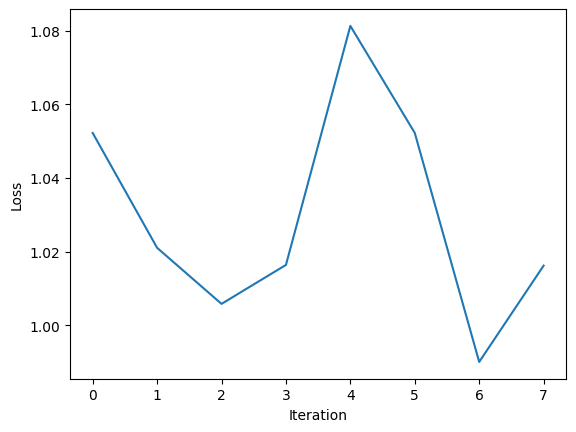

In [28]:


vqc.fit(X_train, y_train)

## Performance evaluation

In [ ]:
def performance_VQC(X, y, name):
    y_pred = vqc.predict(X)
    print(classification_report(y, y_pred))
    print(f'{confusion_matrix(y, y_pred)} = confusion matrix for {name} set \n')
    return y_pred
    

y_pred_train = performance_VQC(X_train, y_train, 'train')
y_pred_test = performance_VQC(X_test, y_test, 'test')